# Hotel Reviews Classification Project P36
### ExcelR
### Mentors : Vinod Sir , Munmun Mam
### 

## Project Submitted by Team G3 - The Blackholes
### Alok, Pooja, Yogesh, Manthan, Ashish, Shakila
### 

## Executive Summary

1. Data 
We have hotel reviews which is in text format. The train data has Ratings from 1 to 5 , we converted it to 3 levels  
There are about 14000 reviews in train data and the test data has about 6000 reviews

1. We have done EDA   
Removed punctuations, tags, stopwords, done lemmatization, etc
contractions replaced ( replacing n't  and 'nt  by not). Added many more words to list of stopwords
removing word 'not' from list of stopwords

2. We have run models using term-frequency binary, only tf, tf-idf

3. Include new features like Length of original reviews and Length of clean_reviews   
Have run different models   
Logistic Regression, KNN, Decision Trees, Gaussian Naive Bayes, Multinomial  Naive Bayes   
accuracy and f1-macro-scores were very poor

4. Sentiments using TextBlob - polarity and subjectivity   
Have run models using both as well as separately, poor accuracy and f1-macro-scores 
for subjectivity scores were still lesser as compared to that of polarity  

5. We have also run SVM, Decision tress, Random forest, KNN, Multinomial Naive Bayes - but poor results

6. cross-validation with number of folds (10)    
Since data is imbalanced , we have run using  cross-validation and found out f1-macro-scores
for all. Also used SMOTE to balance the data, but poor results

7. we have run models using 5-rating level and 3-rating level
The results of later have been better, hence continued with 3-level rating   

8. We have run using Multinomial Logistic Regression and SVM (kernel=rbf)
The Multinomial Logistic Regression  gave better results with 3000 featutes and 3-level rating.   
Hence we used it for deployment

10. Deployment done using Flask




In [1]:
# To get output for all codes run in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Importing libraries for running different models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [4]:
# Libraries for text preprocessing
import re
import nltk

#nltk.download('stopwords')
from nltk.corpus import stopwords # import stopwords 

#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer # to lemmatize the words

from nltk.tokenize import RegexpTokenizer, word_tokenize # to tokenize sentences into words

## Loading Dataset and  Its details

In [5]:
# data = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\train.csv")
data = pd.read_csv("train.csv")

In [6]:
data.shape
data.head(3) # (14343, 3)

(14343, 3)

ID                                             Review  Rating
0   0  exceptional service nice all-around daughter s...       5
1   1  beautiful relaxing jw marriott desert ridge re...       5
2   2  great location great location 5 mins subway ta...       5

In [7]:
data.columns;data.info()

Index(['ID', 'Review', 'Rating'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14343 entries, 0 to 14342
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      14343 non-null  int64 
 1   Review  14343 non-null  object
 2   Rating  14343 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 336.3+ KB


### Finding duplicate reviews

In [8]:
new_Reviews = list(set(data.Review)) # removes duplicate reviews
len(new_Reviews) # 14343
# no review has been duplicated

14343

### Finding Missing values

In [9]:
data.isnull().sum()
# no missing values in the data

ID        0
Review    0
Rating    0
dtype: int64

### Combining Ratings to form 3 level ratings

In [10]:
# Previously we have performed various ML algorithms on 5 level ratings, but the prediction was very low
# for level-3 (model was confusing between 2,3,4). Hence we have combined ratings to get only 3-levels

In [11]:
 # for 5 level ratings frequency and proportion
data['Rating'].value_counts()
data['Rating'].value_counts(normalize=True)

5    6436
4    4172
3    1510
2    1248
1     977
Name: Rating, dtype: int64

5    0.448721
4    0.290874
3    0.105278
2    0.087011
1    0.068117
Name: Rating, dtype: float64

In [12]:
data['Rating_3levels'] = None
for index, rows in data.iterrows():
    if(rows['Rating'] >= 1 and rows['Rating'] < 3):
        data.at[index, 'Rating_3levels'] = '1Low'
    elif(rows['Rating'] == 3):
        data.at[index,'Rating_3levels'] = '2Medium'
    elif(rows['Rating'] > 3 and rows['Rating'] <= 5 ):
        data.at[index,'Rating_3levels'] = '3High'
data.head()

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

  Rating_3levels  
0          3High  
1          3High  
2          3High  
3        2Medium  
4          3High

### Rating column

In [13]:

data.Rating_3levels.value_counts() # for 3-level ratings

3High      10608
1Low        2225
2Medium     1510
Name: Rating_3levels, dtype: int64

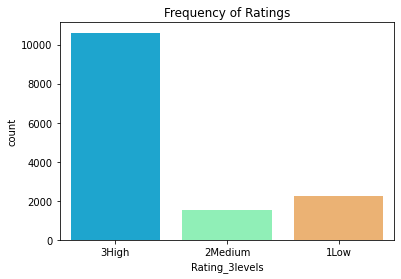

In [14]:

sns.countplot(x='Rating_3levels',data=data , palette='rainbow').set_title("Frequency of Ratings");

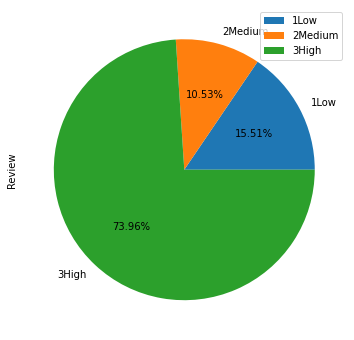

In [15]:
data.groupby("Rating_3levels").count().plot.pie(y="Review",autopct="%.2f%%",figsize=(6,6));

In [16]:
# finding length of the reviews
data['Length_Review'] = data['Review'].apply(len)
data.head()

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

  Rating_3levels  Length_Review  
0          3High            937  
1          3High            791  
2          3High            473  
3        2Medium            342  
4          3High            244

In [17]:
data['Length_Review'].max() # the largest review has  13501 letters
data['Length_Review'].min() # the smallest has 44 letters

13501

44

In [18]:
fig = px.histogram(data, 
                   x='Length_Review', 
                   color='Rating_3levels', 
                   color_discrete_sequence=["#B6E880", "#FFA15A", "#FECB52", "#00CC96", "#EF553B"],
                   title="Review length distributions"
                  )

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0,r=0,b=0)
)
# Distributions cannot be separated, are overlapping


# Text Pre-processing

In [19]:
# Replacing contractions (shorter vesions of words) with full word (n't , 'nt  as not)
for index, row in data.iterrows():
    phrase = row['Review']
    phrase = phrase.lower() #Convert to lowercase
    phrase = re.sub(r"n\'t", " not", phrase) # replace n't  with not
    phrase = re.sub(r"\'nt", " not", phrase) # replace 'nt  with not 
    data.at[index, 'Review_2'] = phrase
data[0:3]

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

  Rating_3levels  Length_Review  \
0          3High            937   
1          3High            791   
2          3High            473   

                                            Review_2  
0  exceptional service nice all-around daughter s...  
1  beautiful relaxing jw marriott desert ridge re...  
2  great location great location 5 mins subway ta...

In [20]:
# TEXT NORMALIZATION   or PRE-PROCESSING

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english")) -set(["not"])
##Creating a list of custom stopwords
new_words = ['n',"th","hotel",'hotels','room','rooms','restaurant','restaurants','e','ca','nd','wo','el','etc']
stop_words = stop_words.union(new_words)
corpus=[]
for index, row in data.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', row['Review_2']) # Remove punctuations    
    # text = text.lower() #Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)  # remove tags
    text = re.sub("(\\d|\\W)+"," ",text)  # remove special characters and digits
    text = text.split()  # Convert to list from string
    
    #Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word  in stop_words] 
    text_string = " ".join(text)
    corpus.append(text_string)
    data.at[index, 'clean_review'] = text_string
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

  Rating_3levels  Length_Review  \
0          3High            937   
1          3High            791   
2          3High            473   

                                            Review_2  \
0  exceptional service nice all-around daughter s...   
1  beautiful relaxing jw marriott desert ridge re...   
2  great location great location 5 mins subway ta...   

                                        clean_review  
0  exceptional service nice around daughter staye...  
1  beautiful relaxing jw marriott desert ridge re...  
2  great location great location min subway take ...

In [21]:
corpus[0]

'exceptional service nice around daughter stayed well priced night king suite weekend night really impressed exceptionally welcoming service time reservation departure employee talked really friendly eager help question amazed day age l shaped pool tiny looked like fun kid hot tub exercise well breakfast abundant make waffle add scrambled egg bacon sausage fruit available bagel muffin oatmeal yogurt wanted morning sort long line waiting make waffle waiting scrambled egg picky really nice asked away freeway reading review earlier bit noisy hey city felt like deluxe considering reasonable price nice bedding art wall really liked space needle bit window shuttle run hourly not reserve certain place certain time worked shuttle missed minute needed return space needle promptly paid cab fare asked definitely need stay near downtown seattle'

In [22]:
data.drop(['Review_2'], axis=1,inplace=True)
data

ID                                             Review  Rating  \
0          0  exceptional service nice all-around daughter s...       5   
1          1  beautiful relaxing jw marriott desert ridge re...       5   
2          2  great location great location 5 mins subway ta...       5   
3          3  pleased nice safe hotel, flower market hotel v...       3   
4          4  excellent hotel service great hotel excellent ...       4   
...      ...                                                ...     ...   
14338  14338  hotel madrid hotel perfect, location tiny quie...       5   
14339  14339  excellent hotel stay florence hotel chosen tri...       5   
14340  14340  great place relax know looking vacation book t...       4   
14341  14341  better just got week seattle loved minute, pac...       3   
14342  14342  stay clear, internet reservation friday rang h...       1   

      Rating_3levels  Length_Review  \
0              3High            937   
1              3High            791   
2              3High            473   
3            2Medium            342   
4              3High            244   
...              ...            ...   
14338          3High            221   
14339          3High            405   
14340          3High           1697   
14341        2Medium            214   
14342           1Low            396   

                                            clean_review  
0      exceptional service nice around daughter staye...  
1      beautiful relaxing jw marriott desert ridge re...  
2      great location great location min subway take ...  
3      pleased nice safe flower market vast array mai...  
4      excellent service great excellent location cou...  
...                                                  ...  
14338  madrid perfect location tiny quiet street cent...  
14339  excellent stay florence chosen tripadviser bes...  
14340  great place relax know looking vacation book t...  
14341  better got week seattle loved minute pacific p...  
14342  stay clear internet reservation friday rang ho...  

[14343 rows x 6 columns]

In [23]:
# Finding total words in Cleaned review
clean_review_words = " ".join(data['clean_review'])
clean_review_words = clean_review_words.split()
len(clean_review_words)# 1368889 words are present  
 
# 13,68,889 words are present in cleaned reviews (includes duplicate words as well)

1368889

In [24]:
# finding frequency of all words 

words_all = len(clean_review_words)
words_all # 1368889

word_dist = nltk.FreqDist(clean_review_words)

freq_data_all = pd.DataFrame(word_dist.most_common(words_all), columns=['Word','Frequency'])

freq_data_all['percentFreq_all'] =(freq_data_all.Frequency / freq_data_all.Frequency.sum())*100 
freq_data_all['percentFreq_unique'] =(freq_data_all.Frequency / len(freq_data_all))*100 

len(freq_data_all) # 37558
freq_data_all[0:10]

words_all_1= freq_data_all.Frequency.sum() 
words_all_1 # 1368889

# word "not" has not been removed from our list 
# we have total 13,68,889 words
# we have 37,558 unique words  

1368889

37558

Word  Frequency  percentFreq_all  percentFreq_unique
0       not      35612         2.601526           94.818680
1     great      15197         1.110170           40.462751
2      good      12287         0.897589           32.714735
3     staff      11700         0.854708           31.151819
4      stay      10885         0.795170           28.981841
5     night      10326         0.754334           27.493477
6       day       9586         0.700276           25.523191
7      time       9208         0.672662           24.516747
8      nice       8837         0.645560           23.528942
9  location       8139         0.594570           21.670483

1368889

## N-gram Analaysis

### Tokenisation

In [25]:
from nltk.tokenize import word_tokenize
corpusdata=data['clean_review'].apply(word_tokenize).tolist()
len(corpusdata),data.shape[0]

(14343, 14343)

In [26]:
corpusdata = np.asarray(corpusdata)
targets = np.asarray(data['Rating'].tolist())

In [27]:
data.Review[0]

"exceptional service nice all-around daughter stayed well-priced hotel 99 night king suite weekend nights really impressed exceptionally welcoming service time reservation departure, hotel employee talked really friendly eager help questions, amazed day age.the l-shaped hotel pool tiny looked like fun kids hot-tub exercise room well.breakfast abundant, make waffles add scrambled eggs bacon sausage fruit, available bagels muffins oatmeal yogurt just wanted, morning sort long line waiting make waffles waiting scrambled eggs, picky.our room really nice asked away freeway reading reviews earlier bit noisy hey city, felt like deluxe room considering reasonable price nice bedding art walls really liked, space needle bit window.the shuttle runs hourly n't reserve certain place certain time, worked shuttle missed just minute needed return space needle promptly paid cab fare having asked, definitely need stay near downtown seattle,  "

In [28]:
corpusdata[0]

['exceptional',
 'service',
 'nice',
 'around',
 'daughter',
 'stayed',
 'well',
 'priced',
 'night',
 'king',
 'suite',
 'weekend',
 'night',
 'really',
 'impressed',
 'exceptionally',
 'welcoming',
 'service',
 'time',
 'reservation',
 'departure',
 'employee',
 'talked',
 'really',
 'friendly',
 'eager',
 'help',
 'question',
 'amazed',
 'day',
 'age',
 'l',
 'shaped',
 'pool',
 'tiny',
 'looked',
 'like',
 'fun',
 'kid',
 'hot',
 'tub',
 'exercise',
 'well',
 'breakfast',
 'abundant',
 'make',
 'waffle',
 'add',
 'scrambled',
 'egg',
 'bacon',
 'sausage',
 'fruit',
 'available',
 'bagel',
 'muffin',
 'oatmeal',
 'yogurt',
 'wanted',
 'morning',
 'sort',
 'long',
 'line',
 'waiting',
 'make',
 'waffle',
 'waiting',
 'scrambled',
 'egg',
 'picky',
 'really',
 'nice',
 'asked',
 'away',
 'freeway',
 'reading',
 'review',
 'earlier',
 'bit',
 'noisy',
 'hey',
 'city',
 'felt',
 'like',
 'deluxe',
 'considering',
 'reasonable',
 'price',
 'nice',
 'bedding',
 'art',
 'wall',
 'really',


In [29]:
corpus1 = data[data['Rating_3levels'] == '1Low']['clean_review'].apply(word_tokenize).tolist()
corpus2 = data[data['Rating_3levels'] == '2Medium']['clean_review'].apply(word_tokenize).tolist()
corpus3 = data[data['Rating_3levels'] == '3High']['clean_review'].apply(word_tokenize).tolist()


In [30]:
def count_ngrams(corpusdata, n=2, ntop=None):
    ngrams = {}
    
    for clean_review in corpusdata:
        clean_review = tuple(clean_review)
        
        for i in range(0, len(clean_review) - n + 1): 
                # Get the n-gram from i to i+n
                ngram = clean_review[i:i+n]
                
                # check if the n-gram is in the dictionary
                if ngram in ngrams:
                    # Increment the count for this n-gram
                    ngrams[ngram] += 1
                else:
                    # Initialize this n-gram count to 1
                    ngrams[ngram] = 1
                    
    ngrams = pd.DataFrame.from_dict(ngrams, orient='index', columns=['count']).sort_values('count', ascending=False)
    
    ngrams.reset_index(inplace=True)
    
    ngrams['index'] = ngrams['index'].str.join(', ')
    
    
    if (ntop):
        ngrams = ngrams[:ntop]    
        
    return ngrams

### Uni-grams

In [31]:
uni_grams1 = count_ngrams(corpus1, n=1, ntop=10)
uni_grams2 = count_ngrams(corpus2, n=1,ntop=10)
uni_grams3 = count_ngrams(corpus3, n=1,ntop=10)

uni_grams1['Rating_3levels'] = '1Low'
uni_grams2['Rating_3levels'] = '2Medium'
uni_grams3['Rating_3levels'] = '3High'


unigrams = pd.concat([ uni_grams3, uni_grams2, uni_grams1])

In [32]:
import plotly.express as px
from plotly.subplots import make_subplots
fig = px.bar(unigrams, x="index", y="count", color="Rating_3levels", facet_col="Rating_3levels", title='Unigrams of Reviews Rating-wise' ,
             color_continuous_scale=[ "#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)
# words like not, great , staff ,etc are found in all 3 Ratings
# for Rating-1, we have words like food, resort , service - when we look at original reviews say about food ('cold food')


### Bi-grams

In [33]:
bi_grams1 = count_ngrams(corpus1,n=2,ntop=10)
bi_grams2 = count_ngrams(corpus2, n=2,ntop=10)
bi_grams3 = count_ngrams(corpus3, n=2,ntop=10)

bi_grams1['Rating_3levels'] = '1Low'
bi_grams2['Rating_3levels'] = '2Medium'
bi_grams3['Rating_3levels'] = '3High'

bigrams = pd.concat([ bi_grams3, bi_grams2, bi_grams1])

In [34]:
fig = px.bar(bigrams, x="index", y="count", color="Rating_3levels", facet_col="Rating_3levels",  title='Bigrams of Reviews Rating-wise' ,
             color_continuous_scale=[ "#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)
# 

### Tri-grams

In [35]:
tri_grams1 = count_ngrams(corpus1, n=3, ntop=10)
tri_grams2 = count_ngrams(corpus2, n=3, ntop=10)
tri_grams3 = count_ngrams(corpus3, n=3, ntop=10)

tri_grams1['Rating_3levels'] = '1Low'
tri_grams2['Rating_3levels'] = '2Medium'
tri_grams3['Rating_3levels'] = '3High'


tri_grams = pd.concat([ tri_grams3, tri_grams2, tri_grams1])

In [36]:
fig = px.bar(tri_grams, x="index", y="count", color="Rating_3levels", facet_col="Rating_3levels", title='Trigrams of Reviews Rating-wise' ,
             color_continuous_scale=["#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)


# Visualizing positive and negative words using wordcloud

In [37]:
# Finding total words in Cleaned review
clean_review_words = " ".join(data['clean_review'])
clean_review_words = clean_review_words.split()
len(clean_review_words)# 1368889 words are present  
clean_review_words[0:10]
# 13,68,889 words are present in cleaned reviews (includes duplicate words as well)

1368889

['exceptional',
 'service',
 'nice',
 'around',
 'daughter',
 'stayed',
 'well',
 'priced',
 'night',
 'king']

##  Word Cloud - all words

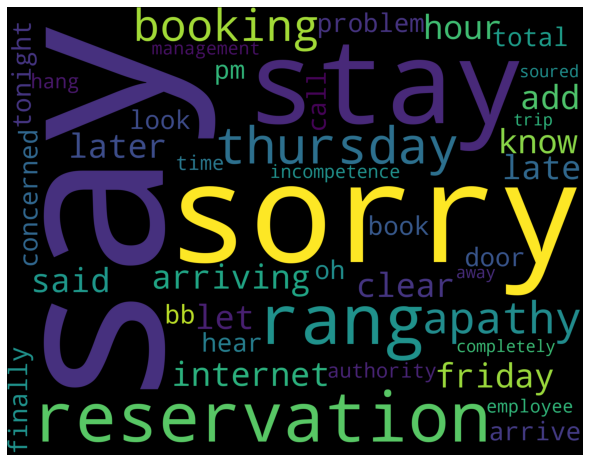

In [38]:
from wordcloud import WordCloud

wordcloud_all = WordCloud(background_color='black', width=1800, height=1400, max_words=100).generate(text_string)
                      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_all) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();


## Positive Word Cloud

In [39]:
# Using positive words 
with open('positive-words.txt','r') as pos:
    poswords = pos.read().split("\n")
poswords = poswords[35:]
poswords[0:6]

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable']

In [40]:
text_pos = " ".join([w for w in clean_review_words if w in poswords])
text_pos[0:10]

'exceptiona'

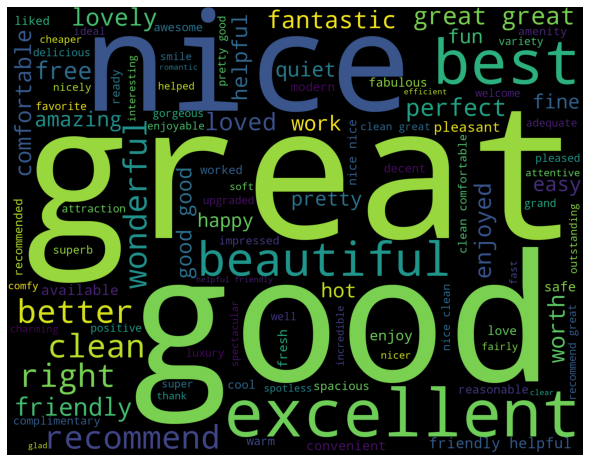

In [41]:
from wordcloud import WordCloud
wordcloud_pos = WordCloud(background_color='black', width=1800, height=1400, max_words=100).generate(text_pos)
                      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();


## Negative Word Cloud

In [42]:
# Using Negative words

with open ('negative-words.txt','r') as neg:
    negwords = neg.read().split("\n")
negwords = negwords[35:]
negwords[0:6]

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably']

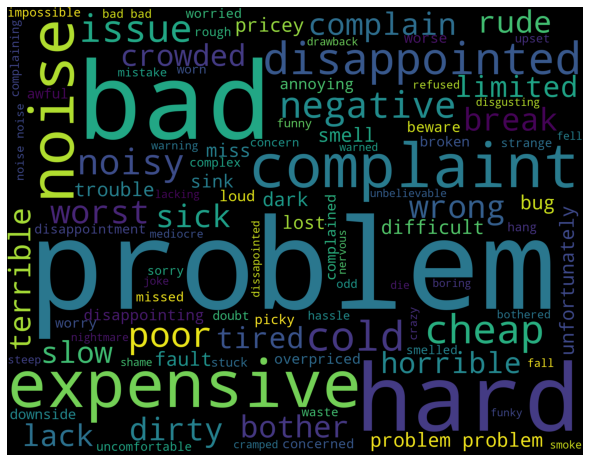

In [43]:
text_neg = " ".join ([w for w in clean_review_words if w in negwords])

wordcloud_neg = WordCloud(background_color='black', width=1800, height=1400, max_words=100).generate(text_neg)
                      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();


# Sentiment Analysis

<Figure size 720x720 with 0 Axes>

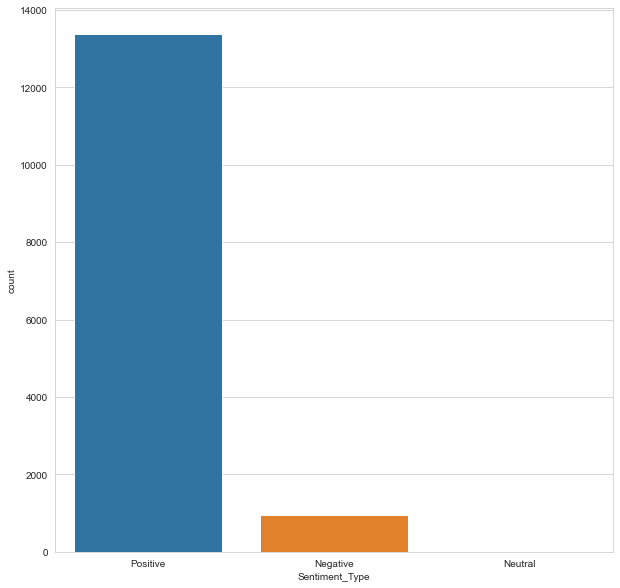

In [44]:
from textblob import TextBlob
# conda install -c conda-forge textblob
bloblist_desc = list()

data_clean_review_str=data['clean_review'].astype(str)
for row in data_clean_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    data_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
 
def f(data_polarity_desc):
    if data_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif data_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

data_polarity_desc['Sentiment_Type'] = data_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=data_polarity_desc)

# there are a large number of positive sentiments, very less negative, and very very less neutral sentiments 

## Sentiment Analysis Using VADER

In [45]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
data["sentiments"] = data["Review"].apply(lambda x: sid.polarity_scores(x))

data = pd.concat([data.drop(['sentiments'], axis=1), data['sentiments'].apply(pd.Series)], axis=1)

data.head()

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

  Rating_3levels  Length_Review  \
0          3High            937   
1          3High            791   
2          3High            473   
3        2Medium            342   
4          3High            244   

                                        clean_review    neg    neu    pos  \
0  exceptional service nice around daughter staye...  0.046  0.691  0.263   
1  beautiful relaxing jw marriott desert ridge re...  0.046  0.493  0.461   
2  great location great location min subway take ...  0.083  0.557  0.361   
3  pleased nice safe flower market vast array mai...  0.000  0.750  0.250   
4  excellent service great excellent location cou...  0.000  0.532  0.468   

   compound  
0    0.9877  
1    0.9970  
2    0.9808  
3    0.9281  
4    0.9718

In [46]:
# add number of characters columns
data["nb_chars"] = data["Review"].apply(lambda x: len(x))

# add number of words column
data["nb_words"] = data["Review"].apply(lambda x: len(x.split(" ")))

data.head()

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

  Rating_3levels  Length_Review  \
0          3High            937   
1          3High            791   
2          3High            473   
3        2Medium            342   
4          3High            244   

                                        clean_review    neg    neu    pos  \
0  exceptional service nice around daughter staye...  0.046  0.691  0.263   
1  beautiful relaxing jw marriott desert ridge re...  0.046  0.493  0.461   
2  great location great location min subway take ...  0.083  0.557  0.361   
3  pleased nice safe flower market vast array mai...  0.000  0.750  0.250   
4  excellent service great excellent location cou...  0.000  0.532  0.468   

   compound  nb_chars  nb_words  
0    0.9877       937       134  
1    0.9970       791       108  
2    0.9808       473        73  
3    0.9281       342        51  
4    0.9718       244        33

In [47]:
# highest positive sentiment reviews (with more than 5 words)
data[data["nb_words"] >= 5].sort_values("pos", ascending = False)[["Review", "pos"]].head(10)

Review    pos
12780  perfect, impressive place, want clean comfy ro...  0.818
13758  hotel great hotel great money clean good restu...  0.799
10169  regular, amazing value, stay hotel let, great ...  0.796
10350  fantastic value money good value money, great ...  0.792
1517   great hotel loved hotel, location perfect staf...  0.787
10518  incredible value great price expedia package, ...  0.777
4919   best hotel, hotel gorgeous, beautiful clean sp...  0.763
6643   fabulous trip stayed just night wish longer, h...  0.757
3057   wonderful hotel perfect place stay excellent l...  0.756
10634  location superb, rooms good size appointed sta...  0.753

### Most Positive Sentiment reviews based on Compound scores

In [48]:
# highest positive sentiment reviews (with more than 5 words)
data[data["nb_words"] >= 5].sort_values("compound", ascending = False)[["Review", "pos","compound"]].head(10)

Review    pos  compound
7122   ocean blue excellent resort, boyfriend mid-20_...  0.324    0.9999
8469   melia caribe wonderful, just returned wonderfu...  0.244    0.9998
2629   great weather time secrets husband couple frie...  0.382    0.9998
1348   ca n't wait till year, 2nd 16th 2008we stayed ...  0.318    0.9998
8207   bravo bavaro knew not five-star hotel incredib...  0.234    0.9998
2801   ca n't wait, time dominican republic staying b...  0.277    0.9998
2454   superb, spent 2 weeks 13/03-27/03 hotel absolu...  0.340    0.9998
14170  perfect days paradise, waited home write guest...  0.232    0.9997
4359   absolutely perfect way, excellence excellente,...  0.410    0.9997
4166   6/1/06 6/7/06 great time n't, ok think importa...  0.243    0.9997

In [49]:
# lowest negative sentiment reviews (with more than 5 words)
data[data["nb_words"] >= 5].sort_values("neg", ascending = False)[["Review", "neg"]].head(10)

Review    neg
7808   bad hotel really awful place dirty room rude s...  0.646
13106  bad bad bad hotel verry bad pls not stay, clos...  0.645
6908   worn noisy worn noisy, remodel future, prices ...  0.527
12728  extremely disappointing experience disappointi...  0.507
10332  worst hotel room awful no windows poor lightin...  0.477
5671   eh, no didnt like room hotel super small does ...  0.461
9660   warwick bad good reviews warwick shocks staff ...  0.458
2677   food great rest service poor stayed hotel time...  0.440
12565  horrible stay bad staff rooms horrible staff u...  0.438
9486   ritz canal street terrible location equally ho...  0.438

### Most Negative Sentiment Reviews based on Compound Scores

In [50]:
# lowest negative sentiment reviews (with more than 5 words)
data[data["nb_words"] >= 5].sort_values("compound", ascending = True)[["Review", 'neg',"compound"]].head(10)

Review    neg  compound
1669   414 hotel worst accomodation experience life, ...  0.180   -0.9974
5160   dreams nightmares husband second time resort, ...  0.315   -0.9941
6722   great vomiting pass june 16 june 23 family lef...  0.187   -0.9932
10819  majestic hotel putan cana-awful assuming peopl...  0.275   -0.9923
6000   ok not great told excellence punta cana best e...  0.232   -0.9912
6759   traveler beware worse hotel not all-inclusive ...  0.186   -0.9911
6197   horrible experience terrible service experienc...  0.268   -0.9897
14266  gross problems hotel, town wedding just wanted...  0.302   -0.9894
9883   worst jw marriott stayed, 1st glance jw marrio...  0.181   -0.9892
12366  ok just returned staying 7 days ocean blue inc...  0.212   -0.9889

# Named Entity Recognition / Entity Extraction

In [51]:
# conda install -c conda-forge spacy-model-en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm')

Let’s find out the most frequent named entities in our corpus. For this, we will build a data frame consisting of all the named entities and their types.

In [52]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [53]:
#To find top occuring entities and their types

In [54]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:20]

0        1        2        3     4     5      6         7   \
Entity Name  night  morning  evening   second  week  hour  daily  american   
Entity Type   TIME     TIME     TIME  ORDINAL  DATE  TIME   DATE      NORP   
Frequency     3349     1163     1017      973   702   583    516       512   

                   8     9        10         11    12        13      14  \
Entity Name       one   day  weekend  afternoon  year      half  minute   
Entity Type  CARDINAL  DATE     DATE       TIME  DATE  CARDINAL    TIME   
Frequency         436   396      384        371   353       346     261   

                   15          16     17             18      19  
Entity Name  year old  late night  month  early morning  summer  
Entity Type      DATE        TIME   DATE           TIME    DATE  
Frequency         216         195    187            164     144

In [55]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

0     1         2        3     4    5         6       7   \
Entity Type  TIME  DATE  CARDINAL  ORDINAL  NORP  GPE  QUANTITY  PERSON   
Frequency    9697  7136      1367     1330   563  177        79      33   

                8    9        10   11  
Entity Type  MONEY  ORG  PERCENT  LOC  
Frequency       32    4        2    1

# Topic Modelling using LDA

In [56]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(corpusdata, min_count=10)
trigram = Phrases(bigram[corpusdata])

for idx in range(len(corpusdata)):
    for token in bigram[corpusdata[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            corpusdata[idx].append(token)
    for token in trigram[corpusdata[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            corpusdata[idx].append(token)

In [92]:

# Create a dictionary representation of the documents.
dictionary = Dictionary(corpusdata)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))


c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of unique words in initital documents: 43192
Number of unique words after removing rare and common words: 10399


In [58]:
#Creating term document matrix
corpus_1 = [dictionary.doc2bow(doc) for doc in corpusdata]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus_1))

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of unique tokens: 10399
Number of documents: 14343


In [59]:
# Set training parameters.
num_topics = 4
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0] # load dictionary
id2word = dictionary.id2token


model = LdaModel(corpus=corpus_1, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every,random_state=12)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [60]:
viz = pyLDAvis.gensim_models.prepare(model, corpus_1, dictionary)
viz

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.190834  0.066641       1        1  33.054874
3      0.012077 -0.249695       2        1  31.890793
1     -0.087012  0.093308       3        1  27.316423
2      0.265769  0.089746       4        1   7.737910, topic_info=                  Term         Freq        Total Category  logprob  loglift
169             resort  6235.000000  6235.000000  Default  30.0000  30.0000
1530        punta_cana  2945.000000  2945.000000  Default  29.0000  29.0000
264        minute_walk  3150.000000  3150.000000  Default  28.0000  28.0000
254   walking_distance  2698.000000  2698.000000  Default  27.0000  27.0000
18                city  3039.000000  3039.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
113          beautiful   385.899593  3326.091482   Topic4  -5.6294   0.4051
182               want   366.849599  3073.007147   Topic4  -5.6801   0.4336
869                bus   342.935555  1707.778163   Topic4  -5.7475   0.9536
8                 away   342.313301  2892.475218   Topic4  -5.7493   0.4249
184          wonderful   337.937481  2852.717949   Topic4  -5.7621   0.4259

[268 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1100      3  0.912760         activity
1100      4  0.086342         activity
2964      3  0.999033  air_conditioned
1243      1  0.998806  air_conditioner
109       1  0.234214          airport
...     ...       ...              ...
419       2  0.013831             work
419       3  0.346354             work
5869      3  0.998827        work_hard
3198      3  0.391467      worth_money
3198      4  0.607512      worth_money

[448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

## Exploring  4 Key Topics - 5 level rating

In [61]:
def explore_topic(lda_model, topic_number, topn, output=True):
    
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:40} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [62]:
topic_summaries = []
print(u'{:40} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:10]]

term                                     frequency

Topic 0 |---------------------

desk                                     0.006
check                                    0.006
floor                                    0.005
booked                                   0.004
door                                     0.004
star                                     0.004
problem                                  0.004
guest                                    0.004
hour                                     0.004
shower                                   0.004
Topic 1 |---------------------

resort                                   0.016
punta_cana                               0.008
water                                    0.006
drink                                    0.006
beautiful                                0.006
buffet                                   0.005
trip                                     0.005
vacation                                 0.005
went                                  

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Figure size 576x504 with 0 Axes>

<AxesSubplot:xlabel='Rating', ylabel='count'>

Text(0.5, 1.0, 'Topics Distribution by rating')

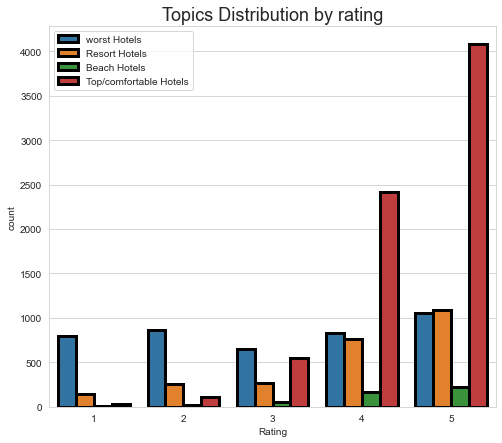

<Figure size 576x504 with 0 Axes>

[Text(0, 0, 'Worst hotels'),
 Text(1, 0, 'Resort Hotels'),
 Text(2, 0, 'Beach Hotels'),
 Text(3, 0, 'Top/comfortable Hotels')]

Text(0.5, 1.0, 'Topics Distribution')

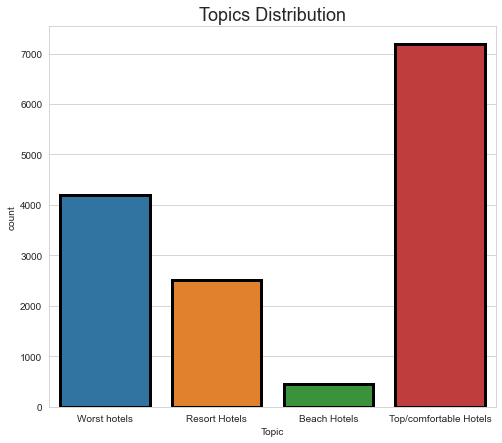

In [63]:
# attach topics to data
all_topics = model.get_document_topics(corpus_1, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
data['Topic'] = all_topics_numpy.argmax(axis=1)

# plot topics distribution by rating
plt.figure(figsize=(8,7))
sns.countplot(data=data,x="Rating",hue="Topic",edgecolor="black",linewidth=3)
plt.legend(['worst Hotels',"Resort Hotels","Beach Hotels","Top/comfortable Hotels"])
plt.title('Topics Distribution by rating',size=18)
plt.show()

# plot topics distribution 
plt.figure(figsize=(8,7))
ax=sns.countplot(data=data,x="Topic",edgecolor="black",linewidth=3)
ax.set_xticklabels(['Worst hotels',"Resort Hotels","Beach Hotels","Top/comfortable Hotels"])
plt.title('Topics Distribution',size=18)
plt.show()

## Exploring  4 Key Topics - 3 level rating

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Figure size 576x504 with 0 Axes>

<AxesSubplot:xlabel='Rating_3levels', ylabel='count'>

Text(0.5, 1.0, 'Topics Distribution by rating')

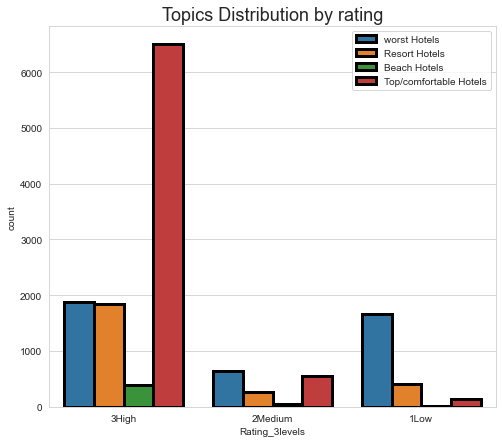

<Figure size 576x504 with 0 Axes>

[Text(0, 0, 'Worst hotels'),
 Text(1, 0, 'Resort Hotels'),
 Text(2, 0, 'Beach Hotels'),
 Text(3, 0, 'Top/comfortable Hotels')]

Text(0.5, 1.0, 'Topics Distribution')

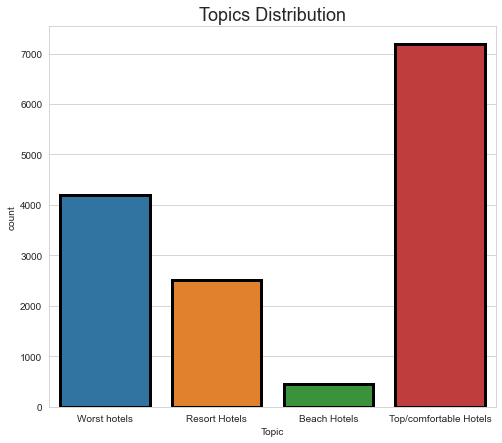

In [64]:
# attach topics to data
all_topics = model.get_document_topics(corpus_1, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
data['Topic'] = all_topics_numpy.argmax(axis=1)

# plot topics distribution by rating
plt.figure(figsize=(8,7))
sns.countplot(data=data,x="Rating_3levels",hue="Topic",edgecolor="black",linewidth=3)
plt.legend(['worst Hotels',"Resort Hotels","Beach Hotels","Top/comfortable Hotels"])
plt.title('Topics Distribution by rating',size=18)
plt.show()

# plot topics distribution 
plt.figure(figsize=(8,7))
ax=sns.countplot(data=data,x="Topic",edgecolor="black",linewidth=3)
ax.set_xticklabels(['Worst hotels',"Resort Hotels","Beach Hotels","Top/comfortable Hotels"])
plt.title('Topics Distribution',size=18)
plt.show()

## Tfidf for train dataset

In [65]:
# get clean-review text column as list
clean_review_list = data['clean_review'].tolist()
type(clean_review_list)
clean_review_list[0]


c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



list

'exceptional service nice around daughter stayed well priced night king suite weekend night really impressed exceptionally welcoming service time reservation departure employee talked really friendly eager help question amazed day age l shaped pool tiny looked like fun kid hot tub exercise well breakfast abundant make waffle add scrambled egg bacon sausage fruit available bagel muffin oatmeal yogurt wanted morning sort long line waiting make waffle waiting scrambled egg picky really nice asked away freeway reading review earlier bit noisy hey city felt like deluxe considering reasonable price nice bedding art wall really liked space needle bit window shuttle run hourly not reserve certain place certain time worked shuttle missed minute needed return space needle promptly paid cab fare asked definitely need stay near downtown seattle'

In [66]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidfconverter = TfidfVectorizer(min_df=750)
tfidfconverter = TfidfVectorizer(max_features=3000)
tfidf_all = tfidfconverter.fit_transform(clean_review_list).toarray()

tfidf_all_names = tfidfconverter.get_feature_names() ; tfidf_all_names[:5]

tfidf_all.shape 
# there are 14343 rows/documents and 429 terms have been generated

tfidf_all_vector =pd.DataFrame(tfidf_all, columns=tfidf_all_names)
tfidf_all_vector.head(3)
# 3000 terms 

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['able', 'absolute', 'absolutely', 'ac', 'accept']

(14343, 3000)

able  absolute  absolutely   ac  accept  acceptable  accepted  access  \
0   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
1   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
2   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   

   accessible  accommodate  ...  yoghurt    yogurt  york  young  younger   yr  \
0         0.0          0.0  ...      0.0  0.107859   0.0    0.0      0.0  0.0   
1         0.0          0.0  ...      0.0  0.000000   0.0    0.0      0.0  0.0   
2         0.0          0.0  ...      0.0  0.000000   0.0    0.0      0.0  0.0   

   yummy  zero  zone  zoo  
0    0.0   0.0   0.0  0.0  
1    0.0   0.0   0.0  0.0  
2    0.0   0.0   0.0  0.0  

[3 rows x 3000 columns]

# Model Building

In [67]:
y = data.Rating_3levels ;
y.shape
y.head()

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(14343,)

0      3High
1      3High
2      3High
3    2Medium
4      3High
Name: Rating_3levels, dtype: object

In [68]:
data.head()

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   
3   3  pleased nice safe hotel, flower market hotel v...       3   
4   4  excellent hotel service great hotel excellent ...       4   

  Rating_3levels  Length_Review  \
0          3High            937   
1          3High            791   
2          3High            473   
3        2Medium            342   
4          3High            244   

                                        clean_review    neg    neu    pos  \
0  exceptional service nice around daughter staye...  0.046  0.691  0.263   
1  beautiful relaxing jw marriott desert ridge re...  0.046  0.493  0.461   
2  great location great location min subway take ...  0.083  0.557  0.361   
3  pleased nice safe flower market vast array mai...  0.000  0.750  0.250   
4  excellent service great excellent location cou...  0.000  0.532  0.468   

   compound  nb_chars  nb_words  Topic  
0    0.9877       937       134      3  
1    0.9970       791       108      1  
2    0.9808       473        73      3  
3    0.9281       342        51      3  
4    0.9718       244        33      3

In [69]:
# # Splitting dataset in 80:20 ratio
# frpm previous models. found this ratio to give good results
X_train1,X_test1,y_train1,y_test1 = train_test_split(tfidf_all_vector,y,test_size=0.20,random_state=123,stratify=y)
X_train1.shape # (11474, 3000)
X_test1.shape # (2869, 3000)
y.shape  # 14343 reviews


c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(11474, 3000)

(2869, 3000)

(14343,)

## Support Vector Machines

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy score on train data: 0.9700191737842078
F1 macro score on train data: 0.9379254777964706
              precision    recall  f1-score   support

        1Low       0.97      0.98      0.98      1780
     2Medium       0.99      0.75      0.85      1208
       3High       0.97      1.00      0.98      8486

    accuracy                           0.97     11474
   macro avg       0.98      0.91      0.94     11474
weighted avg       0.97      0.97      0.97     11474



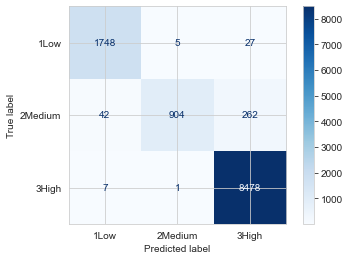

Accuracy score on test data: 0.8529104217497386
F1 macro score on test data: 0.6157097228060256
              precision    recall  f1-score   support

        1Low       0.79      0.72      0.76       445
     2Medium       0.67      0.10      0.17       302
       3High       0.87      0.99      0.92      2122

    accuracy                           0.85      2869
   macro avg       0.78      0.60      0.62      2869
weighted avg       0.83      0.85      0.82      2869



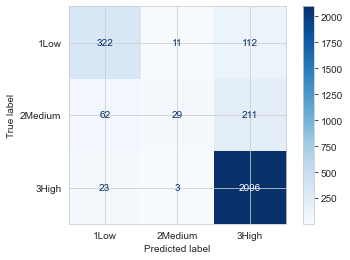

In [70]:
# Running the model on train data and validating on validation data

from sklearn.svm import SVC
model_svm = SVC(random_state=123)
model_svm.fit(X_train1,y_train1)


# for training data
y_pred_train = model_svm.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_svm, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_svm.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_svm, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

## Multinomial Naive Bayes

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy score on train data: 0.8327523095694614
F1 macro score on train data: 0.5468075838638128
              precision    recall  f1-score   support

        1Low       0.86      0.62      0.72      1780
     2Medium       0.90      0.01      0.01      1208
       3High       0.83      0.99      0.90      8486

    accuracy                           0.83     11474
   macro avg       0.86      0.54      0.55     11474
weighted avg       0.84      0.83      0.78     11474



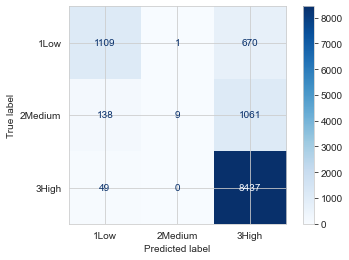

Accuracy score on test data: 0.8229348204949459
F1 macro score on test data: 0.5280169211225284
              precision    recall  f1-score   support

        1Low       0.85      0.58      0.69       445
     2Medium       0.00      0.00      0.00       302
       3High       0.82      0.99      0.90      2122

    accuracy                           0.82      2869
   macro avg       0.56      0.52      0.53      2869
weighted avg       0.74      0.82      0.77      2869



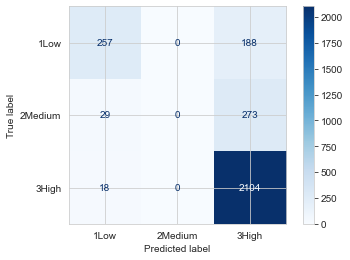

In [71]:
# Running the model on train data and validating on validation data

from sklearn.naive_bayes import MultinomialNB
model_mnb = MultinomialNB()
model_mnb.fit(X_train1,y_train1)

# for training data
y_pred_train = model_mnb.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_mnb, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_mnb.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_mnb, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

## K- Neighbors Classifier

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy score on train data: 0.8181105107198885
F1 macro score on train data: 0.5573512040829353
              precision    recall  f1-score   support

        1Low       0.80      0.51      0.62      1780
     2Medium       0.59      0.09      0.15      1208
       3High       0.82      0.99      0.90      8486

    accuracy                           0.82     11474
   macro avg       0.74      0.53      0.56     11474
weighted avg       0.80      0.82      0.78     11474



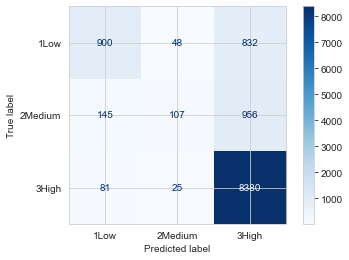

Accuracy score on test data: 0.801673056814221
F1 macro score on test data: 0.513704591974264
              precision    recall  f1-score   support

        1Low       0.78      0.47      0.59       445
     2Medium       0.28      0.04      0.06       302
       3High       0.81      0.98      0.89      2122

    accuracy                           0.80      2869
   macro avg       0.62      0.50      0.51      2869
weighted avg       0.75      0.80      0.75      2869



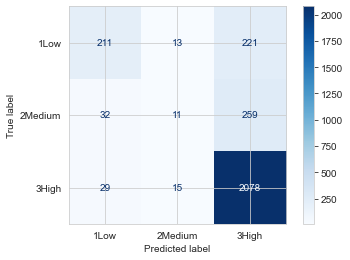

In [72]:
# KNN on tfidf using  n_neighbors=11
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=11)
model_knn.fit(X_train1,y_train1)

# for training data
y_pred_train = model_knn.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_knn, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_knn.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_knn, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

## Decision Tree

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy score on train data: 1.0
F1 macro score on train data: 1.0
              precision    recall  f1-score   support

        1Low       1.00      1.00      1.00      1780
     2Medium       1.00      1.00      1.00      1208
       3High       1.00      1.00      1.00      8486

    accuracy                           1.00     11474
   macro avg       1.00      1.00      1.00     11474
weighted avg       1.00      1.00      1.00     11474



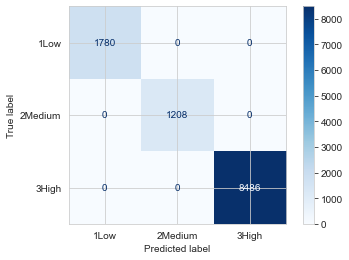

Accuracy score on test data: 0.7410247472987104
F1 macro score on test data: 0.5333142828381345
              precision    recall  f1-score   support

        1Low       0.54      0.51      0.53       445
     2Medium       0.23      0.21      0.22       302
       3High       0.84      0.86      0.85      2122

    accuracy                           0.74      2869
   macro avg       0.54      0.53      0.53      2869
weighted avg       0.73      0.74      0.74      2869



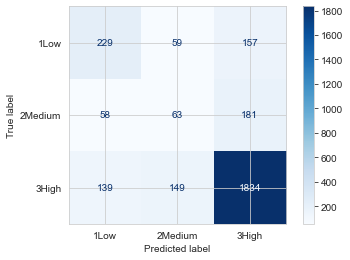

In [73]:
# Using DT functions criterion='entropy',max_features=2000

model_dt = DecisionTreeClassifier(criterion='entropy',max_features=2000,random_state=123)
model_dt.fit(X_train1, y_train1)

# for training data
y_pred_train = model_dt.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_dt, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_dt.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_dt, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

## Random Forest

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



RandomForestClassifier(criterion='entropy', n_jobs=2, oob_score=True,
                       random_state=123)

Accuracy score on train data: 1.0
F1 macro score on train data: 1.0
              precision    recall  f1-score   support

        1Low       1.00      1.00      1.00      1780
     2Medium       1.00      1.00      1.00      1208
       3High       1.00      1.00      1.00      8486

    accuracy                           1.00     11474
   macro avg       1.00      1.00      1.00     11474
weighted avg       1.00      1.00      1.00     11474



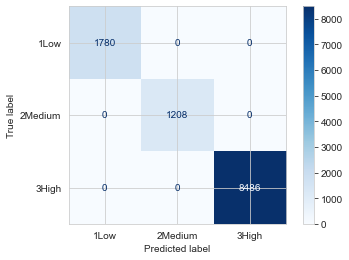

Accuracy score on test data: 0.8184036249564308
F1 macro score on test data: 0.5173127945906125
              precision    recall  f1-score   support

        1Low       0.89      0.52      0.66       445
     2Medium       0.00      0.00      0.00       302
       3High       0.81      1.00      0.89      2122

    accuracy                           0.82      2869
   macro avg       0.57      0.51      0.52      2869
weighted avg       0.74      0.82      0.76      2869



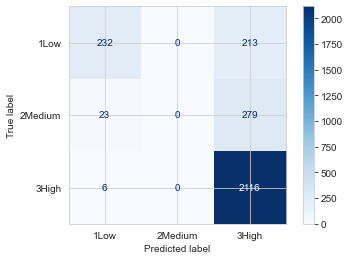

0.8169775143803382

In [74]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_jobs=2, oob_score=True, n_estimators=100, criterion='entropy', random_state=123)
model_rf.fit(X_train1, y_train1)

# for training data
y_pred_train = model_rf.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_rf, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_rf.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_rf, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

model_rf.oob_score_

# FINAL MODEL CHOSEN 

## Tfidf and Multinomial logistic regression using 3000 features

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy score on train data: 0.9043925396548719
F1 macro score on train data: 0.7721511915674389
              precision    recall  f1-score   support

        1Low       0.88      0.87      0.87      1780
     2Medium       0.84      0.35      0.49      1208
       3High       0.91      0.99      0.95      8486

    accuracy                           0.90     11474
   macro avg       0.88      0.74      0.77     11474
weighted avg       0.90      0.90      0.89     11474



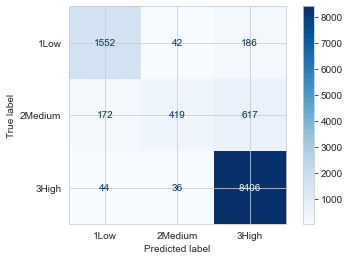

Accuracy score on test data: 0.8567445102823283
F1 macro score on test data: 0.6574101917887235
              precision    recall  f1-score   support

        1Low       0.79      0.72      0.76       445
     2Medium       0.55      0.20      0.29       302
       3High       0.88      0.98      0.93      2122

    accuracy                           0.86      2869
   macro avg       0.74      0.63      0.66      2869
weighted avg       0.83      0.86      0.83      2869



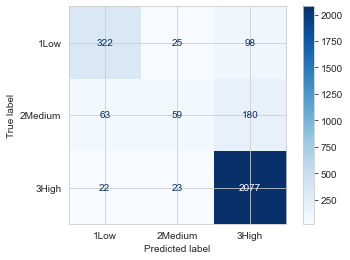

In [75]:
# Running the model on train data and validating on validation data

model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X_train1,y_train1)


# for training data
y_pred_train = model_log.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_log, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_log.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_log, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

## Multinomial logistic regression on full data -  cross validation (kfold=10)

In [76]:
# Multinomial logistic regression on full data -  cross validation (kfold=10)
kfold = KFold(n_splits=10, shuffle=True)
scoring = "f1_macro"

results_X = cross_val_score(LogisticRegression(random_state=123,multi_class='multinomial',
                                             solver='newton-cg'), tfidf_all_vector, y, cv=kfold,scoring=scoring)
print("F1-macro score for Multinomial logistic regression: %.2f%% (%.2f%%)" % (results_X.mean()*100, results_X.std()*100)) 

# F1-macro score : 66.74% (1.88%)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



F1-macro score for Multinomial logistic regression: 66.61% (1.45%)


In [77]:
print("F1-macro score for Multinomial logistic regression: %.2f%% (%.2f%%)" % (results_X.mean()*100, results_X.std()*100)) 

F1-macro score for Multinomial logistic regression: 66.61% (1.45%)


c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Test data

In [78]:
data_test = pd.read_csv("test.csv")

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [79]:
data_test.shape
data_test.head(3)
# 6148 and 2 

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(6148, 2)

ID                                             Review
0   0  just superb rendezvous just perfect property s...
1   1  better close staten island ferry easy subway, ...
2   2  enjoyed stay, just come long weekend barcelona...

## Preprocessing of test data

In [80]:
# Replacing contractions (shorter vesions of words) with full word (n't , 'nt  as not)
for index, row in data_test.iterrows():
    phrase = row['Review']
    phrase = phrase.lower() #Convert to lowercase
    phrase = re.sub(r"n\'t", " not", phrase) # replace n't  with not
    phrase = re.sub(r"\'nt", " not", phrase) # replace 'nt  with not 
    data_test.at[index, 'Review_2'] = phrase
data_test[0:3]

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   
2   2  enjoyed stay, just come long weekend barcelona...   

                                            Review_2  
0  just superb rendezvous just perfect property s...  
1  better close staten island ferry easy subway, ...  
2  enjoyed stay, just come long weekend barcelona...

In [81]:
# TEXT NORMALIZATION   or PRE-PROCESSING

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english")) -set(["not"])
##Creating a list of custom stopwords
new_words = ['n',"th","hotel",'hotels','room','rooms','restaurant','restaurants','e','ca','nd','wo','el','etc']
stop_words = stop_words.union(new_words)

for index, row in data_test.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', row['Review_2']) # Remove punctuations    
    # text = text.lower() #Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)  # remove tags
    text = re.sub("(\\d|\\W)+"," ",text)  # remove special characters and digits
    text = text.split()  # Convert to list from string
    
    #Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word  in stop_words] 
    text_string = " ".join(text)
    data_test.at[index, 'Clean_review'] = text_string
data_test.head(3)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   
2   2  enjoyed stay, just come long weekend barcelona...   

                                            Review_2  \
0  just superb rendezvous just perfect property s...   
1  better close staten island ferry easy subway, ...   
2  enjoyed stay, just come long weekend barcelona...   

                                        Clean_review  
0  superb rendezvous perfect property singapore f...  
1  better close staten island ferry easy subway f...  
2  enjoyed stay come long weekend barcelona staye...

### TFIDF for Test data

In [82]:
# get clean-review text column as list
clean_review_list_test = data_test['Clean_review'].tolist()
type(clean_review_list_test)
clean_review_list_test[0]

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



list

'superb rendezvous perfect property singapore fourth time family stayed property clean staff welcoming standard service second none stayed york terrible westin stamford excellent pricey rendezvous stack count perfect location right not better return therendezvous'

## finding the terms in test data

In [83]:
clean_review_words_test = " ".join(data_test['Clean_review'])
clean_review_words_test = clean_review_words_test.split()
len(clean_review_words_test)
type(clean_review_words_test)
 # 5,72,663 words are present in cleaned reviews of test data (includes duplicate words as well)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



572663

list

In [84]:
# finding frequency of all words in test data

words_all = len(clean_review_words_test)
words_all # 572663

word_dist = nltk.FreqDist(clean_review_words_test)

freq_data_all_test = pd.DataFrame(word_dist.most_common(words_all), columns=['Word','Frequency'])

freq_data_all_test['percentFreq_all'] =(freq_data_all_test.Frequency / freq_data_all_test.Frequency.sum())*100 
freq_data_all_test['percentFreq_unique'] =(freq_data_all_test.Frequency / len(freq_data_all_test))*100 

len(freq_data_all_test) # 23896
freq_data_all_test[0:10]

words_all_1= freq_data_all_test.Frequency.sum() 
words_all_1 # 1368889

# word "not" has not been removed from our list 
# we have total 572663  words
# we have 23878 (23896) unique words 

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



572663

23896

Word  Frequency  percentFreq_all  percentFreq_unique
0       not      15164         2.647980           63.458319
1     great       6288         1.098028           26.314027
2      good       5204         0.908737           21.777703
3     staff       5006         0.874162           20.949113
4      stay       4716         0.823521           19.735521
5     night       4251         0.742321           17.789588
6       day       3898         0.680680           16.312354
7      nice       3810         0.665313           15.944091
8      time       3773         0.658852           15.789253
9  location       3421         0.597385           14.316204

572663

### Transforming test data using tfidf

In [85]:
# Using the train data transformer, we will transform test data

tfidf_test = tfidfconverter.transform(clean_review_list_test).toarray()

# using feature names that were already obtained from train data 
# tfidf_all_names = tfidfconverter.get_feature_names()  
tfidf_all_names[:5]

tfidf_test.shape 

tfidf_test_vector =pd.DataFrame(tfidf_test, columns=tfidf_all_names)
tfidf_test_vector.head(3)
# 3000 terms 

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['able', 'absolute', 'absolutely', 'ac', 'accept']

(6148, 3000)

able  absolute  absolutely   ac  accept  acceptable  accepted  access  \
0  0.000000       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
1  0.000000       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
2  0.075229       0.0         0.0  0.0     0.0         0.0       0.0     0.0   

   accessible  accommodate  ...  yoghurt  yogurt      york  young  younger  \
0         0.0          0.0  ...      0.0     0.0  0.213835    0.0      0.0   
1         0.0          0.0  ...      0.0     0.0  0.000000    0.0      0.0   
2         0.0          0.0  ...      0.0     0.0  0.000000    0.0      0.0   

    yr  yummy  zero  zone  zoo  
0  0.0    0.0   0.0   0.0  0.0  
1  0.0    0.0   0.0   0.0  0.0  
2  0.0    0.0   0.0   0.0  0.0  

[3 rows x 3000 columns]

In [86]:
data.head(2)
data_test.head(2)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   

  Rating_3levels  Length_Review  \
0          3High            937   
1          3High            791   

                                        clean_review    neg    neu    pos  \
0  exceptional service nice around daughter staye...  0.046  0.691  0.263   
1  beautiful relaxing jw marriott desert ridge re...  0.046  0.493  0.461   

   compound  nb_chars  nb_words  Topic  
0    0.9877       937       134      3  
1    0.9970       791       108      1

ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   

                                            Review_2  \
0  just superb rendezvous just perfect property s...   
1  better close staten island ferry easy subway, ...   

                                        Clean_review  
0  superb rendezvous perfect property singapore f...  
1  better close staten island ferry easy subway f...

## Multinomial Logistic regression on train data and evaluating test data

In [87]:
tfidf_all_vector.shape # (14343, 3000)
tfidf_test_vector.shape # (6148, 3000)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(14343, 3000)

(6148, 3000)

In [88]:
### Multinomial Logistic Regression on train and evaluate test data

model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(tfidf_all_vector,y)

# for training data
y_pred_train = model_log.predict(tfidf_all_vector)

print("Accuracy score :" ,accuracy_score(y,y_pred_train))
print("F1 macro score :",f1_score(y,y_pred_train, average='macro'))
print(classification_report(y,y_pred_train))
print(confusion_matrix(y,y_pred_train))

# for test data 
test_pred = model_log.predict(tfidf_test_vector)

# Multinomial Logistic Regression on tfidf using max_featr=3000 terms
# accuracy of train data is 90% and F1-macro score is 77% 

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

Accuracy score : 0.9018336470752283
F1 macro score : 0.7679944913674174
              precision    recall  f1-score   support

        1Low       0.87      0.86      0.87      2225
     2Medium       0.81      0.35      0.49      1510
       3High       0.91      0.99      0.95     10608

    accuracy                           0.90     14343
   macro avg       0.87      0.73      0.77     14343
weighted avg       0.90      0.90      0.89     14343

[[ 1924    59   242]
 [  225   525   760]
 [   60    62 10486]]


In [89]:
type(test_pred)
test_pred.shape
test_pred[0:5]

# converting pred values to df

df_pred = pd.DataFrame(test_pred, columns=['Rating'])
df_pred.shape

data_test.columns
df_pred["ID"] = data_test["ID"]

col_titles = ["ID","Rating"]
df_pred = df_pred.reindex(columns=col_titles)
df_pred.head()

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



numpy.ndarray

(6148,)

array(['3High', '2Medium', '3High', '3High', '3High'], dtype=object)

(6148, 1)

Index(['ID', 'Review', 'Review_2', 'Clean_review'], dtype='object')

ID   Rating
0   0    3High
1   1  2Medium
2   2    3High
3   3    3High
4   4    3High

In [91]:
# Exporting to csv file
df_pred.to_csv(r'df_pred_logreg_final.csv',index=False)

c:\users\lenovo\anaconda3\envs\hotel\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

